# Time-Domain Simulation of a Mach–Zehnder Modulator

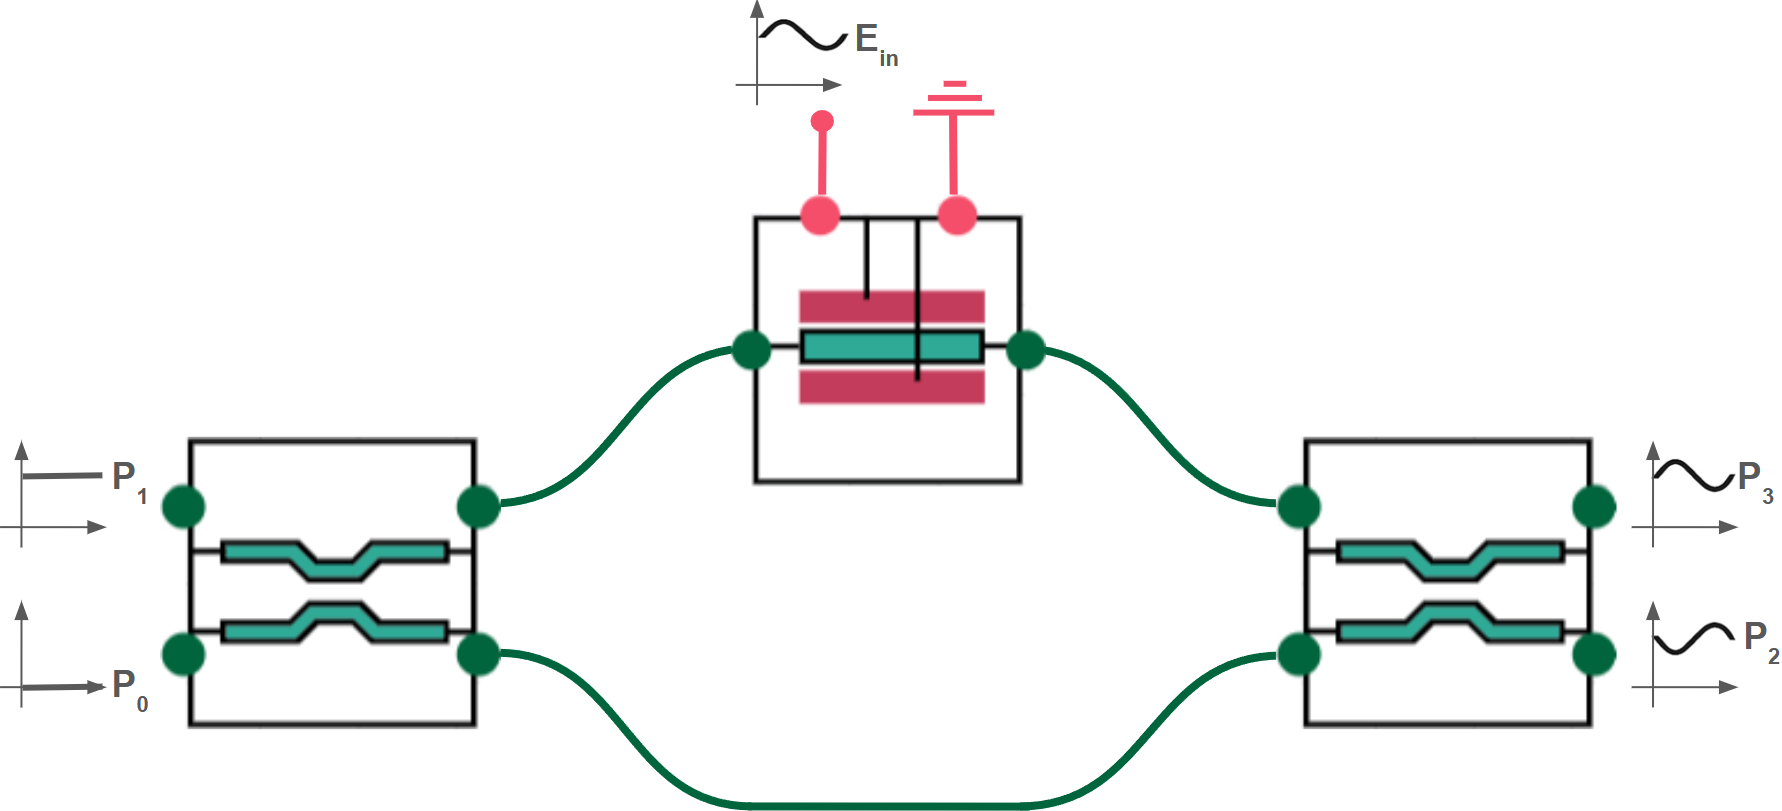

The Mach–Zehnder Modulator (MZM) is a key component in modern optical communication systems, enabling high‑speed modulation of a continuous‑wave (CW) laser signal using an applied electrical drive. It operates by splitting the incoming light into two arms, introducing a controllable phase shift in one arm—typically via a waveguide modulator—and then recombining the signals in an output coupler. The resulting interference pattern modulates the output intensity in response to the drive signal.

In this notebook, we use the `TimeStepper` object to simulate the **time‑domain response** of an MZM. In a PhotonForge time‑domain simulation, components that are inherently described in the **frequency domain** (e.g., S‑matrix models for couplers) are automatically converted to equivalent time‑domain representations using a **poles‑and‑residues fitting approach**. These fitted models are then used alongside any **custom time‑domain models**—such as our electro‑optic phase shifter—to accurately propagate both optical and electrical signals through the circuit over time.

This example demonstrates how to:
1. Implement a custom time‑domain model in PhotonForge.
2. Integrate it into a larger photonic circuit containing both frequency‑domain and time‑domain models.
3. Run a full waveform‑level simulation of an MZM, capturing its dynamic modulation behavior.



In [1]:
import numpy as np
import photonforge as pf
from matplotlib import pyplot as plt

## Configuration and Virtual Port Specifications

We set up PhotonForge to use a basic technology stack and define [virtual ports](../_autosummary/photonforge.virtual_port_spec.rst) for both optical and electrical signals. Virtual ports are **abstract connection points** used to wire components together **without requiring physical layout geometry**. They carry signal type information (e.g., optical or electrical) and mode indices for simulation, enabling us to build and simulate circuits at the schematic level.

Here, because our building blocks are **schematic components** (no layout shapes or physical port locations), we use **virtual electrical and optical ports** to connect them. When we later assemble the MZM, these virtual ports let us route signals and form the circuit graph that PhotonForge simulates in the time domain.


In [2]:
# Set the default technology to the basic PhotonForge technology
pf.config.default_technology = pf.basic_technology()

# Define an optical virtual port specification for future optical connections
opt_vir = pf.virtual_port_spec(classification="optical")

# Define an electrical virtual port specification for future electrical connections
elec_vir = pf.virtual_port_spec(classification="electrical")

## Directional Coupler

Next, we construct a basic rectangular directional coupler and attach [the built-in](../_autosummary/photonforge.DirectionalCouplerModel.rst) `DirectionalCouplerModel` to it. This model is fundamentally an **S‑matrix model** intended for **frequency‑domain** simulations. When running a **time‑domain** simulation, PhotonForge automatically converts this frequency‑domain model into an equivalent time‑domain representation using a **poles‑and‑residues fitting approach**. This fitted model is then used internally to propagate signals in the time domain, ensuring consistency between frequency‑ and time‑domain results without requiring the user to manually perform the conversion.


In [3]:
directional_coupler = pf.DirectionalCouplerModel().black_box_component(opt_vir)

## Bidirectional Optical Phase Shifter – Time-Domain Model

In a real Mach–Zehnder Modulator arm, the waveguide section containing the electrodes supports **light propagation in both directions**. This means that when we model an electro‑optic (EO) phase shifter for circuit‑level simulation, we must account for the fact that **any light entering from either side** will experience a voltage‑controlled phase shift (assuming a lumped phase shifter).

We achieve this by defining a **custom time‑domain model**:

- **Physical Phase Modulation Function**  
  The helper function `eo_model` implements the phase modulation physics:
  $$
  A \ \rightarrow \ A \cdot e^{j \pi V(t) / V_\pi}
  $$
  where $V(t)$ is the applied voltage and $V_\pi$ is the half‑wave voltage of the phase shifter.  
  This form directly follows from the Pockels effect in EO materials.



In [4]:
def eo_model(A, V, Vpi=2):
    """Apply EO phase modulation to complex amplitude A given voltage V and half-wave voltage Vpi."""
    return A * np.exp(1j * np.pi * V / Vpi)

- **EOTimeStepper**  
  Our custom `EOTimeStepper` applies the same modulation function to the optical amplitude traveling in each direction (both forward and backward ports). This ensures the model behaves correctly regardless of which side the light enters from—critical for accurate bidirectional circuit simulations.  

  The `step_single` method also receives an `update_state` flag. This indicates whether the time-stepper should update any **internal state variables** at the current step. In models with memory (for example, those including delay lines, filters, or carrier dynamics), `update_state` is essential to ensure the simulation advances correctly. In our case, the EO phase shifter is **stateless**—its output depends only on the instantaneous input voltage—so we can safely ignore this parameter.


In [5]:
# Define a time-stepper that applies bidirectional EO phase modulation
class EOTimeStepper(pf.TimeStepper):
    """
    TimeStepper that applies a voltage-controlled phase shift to both directions
    of propagation in a waveguide segment.
    """

    def setup_state(self, *, component, time_step, carrier_frequency, **kwargs):
        """Initialize internal state for the time stepper."""
        # Store component reference for accessing ports
        self.component = component

    def reset(self):
        """Reset internal state (no state in this simple model)."""
        pass

    def step_single(self, inputs, time_index: int, update_state: bool, shutdown: bool):
        """
        Perform a single step of bidirectional phase modulation.

        Parameters
        ----------
        inputs : dict
            Port-to-signal mapping for the current time sample.
        time_index : int
            Time series index for the current input.
        update_state : bool
            If True, commit internal state updates for this time step.
            This stepper has no internal state, so we safely ignore it.
        shutdown : bool
            Whether this is the last call to the single stepping function.

        Returns
        -------
        dict
            Updated amplitudes for both optical ports.
        """
        # Electrical input voltage
        Vin = inputs.get("E0@0", 0)

        # Forward and backward propagating optical amplitudes
        A0 = inputs.get("P0@0", 0)
        A1 = inputs.get("P1@0", 0)

        # Apply modulation to each propagation direction
        A1_new = eo_model(A0, Vin)
        A0_new = eo_model(A1, Vin)

        # Return updated amplitudes for both ports
        return {"P1@0": A1_new, "P0@0": A0_new}


pf.register_time_stepper_class(EOTimeStepper)

## Phase Shifter Component

We now create a **component instance** representing the electro-optic phase shifter that will form one arm of our Mach–Zehnder Modulator.

PhotonForge requires each time-stepper to be attached to a model, so we embed our custom `EOTimeStepper` inside an `AnalyticWaveguideModel`. In this example, the waveguide model acts purely as a **hosting wrapper**:  
its optical parameters (`n_eff` and `length`) are *not used* by the phase-shifter logic and have **no physical meaning** in this context. All of the optical behavior—namely the voltage-controlled phase modulation—is governed entirely by the `EOTimeStepper`.

In [6]:
# Create an analytic waveguide model solely as a container for the time-stepper
model = pf.AnalyticWaveguideModel(n_eff=2, length=1)  # parameters arbitrary;

# Attach our custom EO time-stepper, which defines the actual phase-shifting behavior
model.time_stepper = EOTimeStepper()

# Convert the model to a black-box schematic component with an optical virtual port
eops = model.black_box_component(opt_vir)

# Add a virtual electrical port to drive the phase modulation
eops.add_port(pf.Port((0.5, 0.5), 90, spec=elec_vir))

'E0'

## Mach–Zehnder Modulator Assembly


We now integrate the previously defined components to construct the full **MZM**. External ports are collected from the two couplers and the modulator’s electrical control port, making it possible to inject optical signals and apply modulation voltage. A `CircuitModel` is added so that PhotonForge can simulate the device as a network of interconnected subcomponents in the time domain. This completes the layout and connectivity for our MZM, ready for time-domain simulation with optical and electrical inputs.


In [7]:
# Create the Mach–Zehnder Modulator component
mzm = pf.Component("MZM")

# Add the first directional coupler
dc_ref1 = mzm.add_reference(directional_coupler)

# Add the second directional coupler and position it to the right
dc_ref2 = mzm.add_reference(directional_coupler).translate((11, 0))

# Add the EO waveguide modulator in the upper arm between the couplers
eo_ref = mzm.add_reference(eops).translate((9, 1))

# Add all relevant external ports: 2 from first DC, 2 from second DC, 1 from EO modulator
mzm.add_port(
    [dc_ref1["P0"], dc_ref1["P1"], dc_ref2["P2"], dc_ref2["P3"], eo_ref["E0"]], "Port "
)

# Connect upper arm: first DC output (P3) → EO modulator input (P0)
mzm.add_virtual_connection(dc_ref1, "P3", eo_ref, "P0")

# Connect upper arm: EO modulator output (P1) → second DC input (P1)
mzm.add_virtual_connection(eo_ref, "P1", dc_ref2, "P1")

# Connect lower arm directly: first DC output (P2) → second DC input (P0)
mzm.add_virtual_connection(dc_ref1, "P2", dc_ref2, "P0")

# Add a circuit model to simulate the MZM as an interconnected network
mzm.add_model(pf.CircuitModel(), "Circuit")

# Display the assembled MZM
mzm

## Time-Stepper Initialization

We configure the time-stepper with parameters that control **temporal resolution** and the **spectral window** used internally for fitting and dispersion:

**Key parameters:**

- **Time step** $\Delta t$

  We choose $\Delta t$ so that the sampling rate $1/\Delta t$ comfortably exceeds the highest modulation frequency content. For a single tone at $f_m$, a good rule is $\Delta t \ll 1/f_m$ (we use $\Delta t = 10^{-3}/f_m$, i.e., $\sim1000$ samples per period) to reduce numerical error and capture waveform shape.

- **Carrier frequency** $f_c$

  Defines the optical center frequency used in the **envelope formulation**. Rather than directly time-stepping the full optical field oscillating at $\sim 193.4\ \text{THz}$ (corresponding to $\lambda \approx 1550\ \text{nm}$), PhotonForge works in a **rotating reference frame** at the carrier.  
  This means we simulate only the slowly varying **complex envelopes** of the optical signals, which contain the modulation sidebands and device response. All frequency-domain S-matrix data and time-domain signals are therefore referenced relative to this carrier frequency.  

- **Frequency grid** $\{f\}$

  PhotonForge uses the provided frequency grid to construct/fit frequency-domain responses (e.g., S-matrix elements) into time-domain form via poles-and-residues. The grid should **span the carrier and relevant sidebands** produced by the drive and include any device bandwidth/features of interest.  
  - For a single-tone, small-signal case, include at least $f_c \pm f_m$.  
  - For large-signal or non-sinusoidal drives, extend to $f_c \pm N f_m$ (with $N$ covering the significant harmonics).  
  - Use enough points (e.g., 50–200) to ensure a stable fit over the band.

With these choices, we ensure that the time-stepper both resolves the time-domain dynamics and has a frequency window broad and dense enough to capture the spectral content induced by modulation and device dispersion.


In [8]:
# Define the optical carrier frequency (around 1550 nm wavelength)
f_c = 193.4e12  # Hz

# Define the electrical modulation frequency
f_m = 1e9  # Hz

# Choose a time step small enough to resolve the modulation period
time_step = 0.001 / f_m

ts = mzm.setup_time_stepper(
    time_step=time_step,
    carrier_frequency=f_c,
    time_stepper_kwargs={
        "frequencies": np.linspace(f_c - 200 * f_m, f_c + 200 * f_m, 100),
    },
)

Progress: 100% 


## Input Signal Definition

The MZM transfer function is sinusoidal with respect to the applied phase shift. To maximize modulation efficiency for small drive signals, we bias the device at the **quadrature point**—where the output powers at Port 2 and Port 3 are equal.

- **Bias Point Selection**  
  We apply a DC bias of $1\ \text{V}$. With $V_\pi=2\ \text{V}$, the induced phase shift is $\phi_{\text{bias}}=\pi\cdot(1/V_\pi)=\pi/2$, placing the modulator at the midpoint of its transfer curve.

- **Small-Signal Modulation**  
  On top of the DC bias, we add a small cosine drive $V(t)=1+0.1\cos(2\pi f_m t)$, which perturbs the phase slightly around $\pi/2$ so the output power swings symmetrically about the bias point.

- **Optical Inputs and Carrier Handling**  
  We provide **baseband complex envelopes** for the optical inputs: a CW envelope of unity on Port 1 and zero on Port 0. The **optical carrier at** $f_c$ **is included automatically** by the time-stepper configured earlier; there is no need to inject $\cos(2\pi f_c t)$ explicitly in the inputs.

- **TimeSeries Packaging**  
  We bundle the electrical and optical envelopes into a `pf.TimeSeries` object and map them to the corresponding ports for time-domain propagation.

With this setup, we can observe how the MZM output powers at Port 2 and Port 3 evolve over time when biased at quadrature and driven with a small sinusoidal signal.


In [9]:
# Define the final simulation time (1 ns)
t_f = 1e-9  # seconds

# Generate the time vector for the simulation
t = time_step * np.arange(t_f // time_step)

# Electrical drive signal: small cosine modulation around DC bias
E0_in = 1 + 0.1 * np.cos(2 * np.pi * f_m * t)

# Optical input signals
A0_in = np.zeros(len(t))  # No signal at second optical input
A1_in = np.ones(len(t))  # CW optical input at first optical port

# Bundle the input waveforms into a TimeSeries object for the simulation
inputs = pf.TimeSeries(
    values={
        "Port 4@0": E0_in,  # Electrical modulation port
        "Port 0@0": A0_in,  # Lower optical input
        "Port 1@0": A1_in,  # Upper optical input
    },
    time_step=time_step,
)

## Running the Time-Domain Simulation

- **Resetting the Time-Stepper**  
  We call `ts.reset` to ensure the simulation starts with a clean internal state, preventing residual values from previous runs.

- **Executing the Simulation**  
  The `step` method of the time-stepper is used to propagate the defined optical and electrical inputs through the MZM over the simulation time, producing the output waveforms.

The resulting `outputs` object contains the simulated time-domain signals at all output ports of the MZM.


In [10]:
# Reset the time-stepper to ensure a clean simulation start
ts.reset()

# Run the simulation for the given input waveforms
outputs = ts.step(inputs)

Progress: 1000/1000


We validate the MZM time-domain simulation in PhotonForge by directly comparing the output optical powers with results from another commercial software.  
The reference dataset can be downloaded **[here](../examples/MZM_ref_data.zip)**.

As shown in the plot, the PhotonForge simulation agrees closely with the reference across the modulation cycle. One key difference is at the very beginning ($t=0$): the reference data exhibits a sharp artifact, while the PhotonForge result remains smooth. 


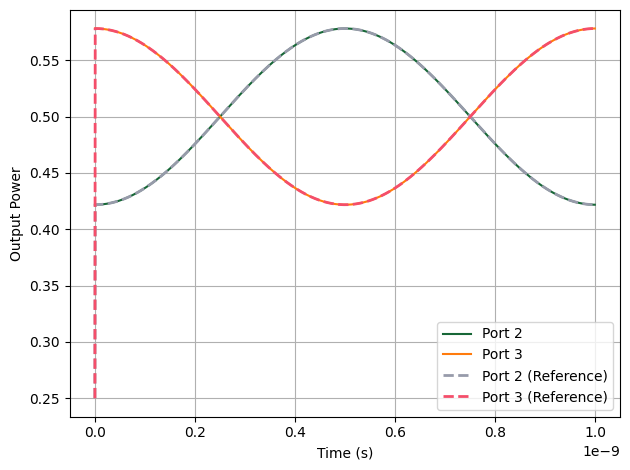

In [11]:
# Plot PhotonForge simulation results for both output ports
plt.plot(t, np.abs(outputs["Port 2@0"]) ** 2, label="Port 2")
plt.plot(t, np.abs(outputs["Port 3@0"]) ** 2, label="Port 3")

# Load reference results from another commercial simulation tool
time3, y3 = np.loadtxt("port2_case1.txt", delimiter=",", skiprows=3, unpack=True)
time4, y4 = np.loadtxt("port3_case1.txt", delimiter=",", skiprows=3, unpack=True)

# Plot reference results with dashed lines
plt.plot(time3, y3, label="Port 2 (Reference)", linewidth=2, linestyle="--")
plt.plot(time4, y4, label="Port 3 (Reference)", linewidth=2, linestyle="--")

# Formatting and display
plt.xlabel("Time (s)")
plt.ylabel("Output Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Large-Signal Modulation and Saturation Behavior

In the previous example, we applied a **small sinusoidal modulation** around the quadrature bias point, which kept the MZM operating in its **linear region**.  
Here, we intentionally increase the modulation depth to demonstrate **saturation effects**.

- **Drive Signal**  
  We use:
  $$
  V(t) = 1 + \cos(2\pi f_m t)
  $$
  The DC bias term ($1\ \text{V}$) still sets the operating point at quadrature ($\phi_{\text{bias}} = \pi/2$), but the added cosine term now has an amplitude large enough to sweep the phase shift well beyond $\pi/2$ in both directions.



In [12]:
E0_in = 1 + np.cos(2 * np.pi * f_m * t)
inputs = pf.TimeSeries(
    values={
        "Port 4@0": E0_in,  # Electrical modulation port
        "Port 0@0": A0_in,  # Lower optical input
        "Port 1@0": A1_in,  # Upper optical input
    },
    time_step=time_step,
)
# Reset the time-stepper to ensure a clean simulation start
ts.reset()
# Run the simulation for the given input waveforms
outputs = ts.step(inputs)

Progress: 1000/1000


**Resulting Behavior**  
  The MZM transfer function is sinusoidal in phase shift, so a large drive signal causes:
  - **Flattening** of the output waveform near its maximum and minimum power levels.
  - Nonlinear distortion due to the fact that the transfer curve is no longer locally linear.

The simulation (solid lines) and reference results (dashed lines) match closely, confirming that our time-domain EO modulator model reproduces the correct **large-signal saturation** behavior.


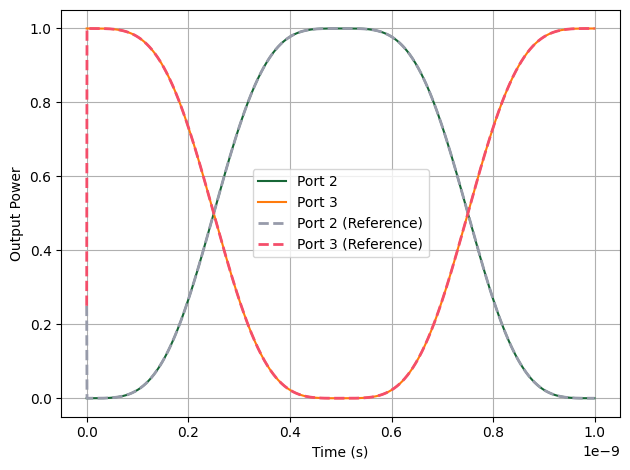

In [13]:
# Plot PhotonForge simulation results for both output ports
plt.plot(t, np.abs(outputs["Port 2@0"]) ** 2, label="Port 2")
plt.plot(t, np.abs(outputs["Port 3@0"]) ** 2, label="Port 3")
plt.ylabel("Power (a.u.)")
plt.xlabel("Time (s)")

# Load reference results from another commercial simulation tool
time3, y3 = np.loadtxt("port2_case2.txt", delimiter=",", skiprows=3, unpack=True)
time4, y4 = np.loadtxt("port3_case2.txt", delimiter=",", skiprows=3, unpack=True)

# Plot reference results with dashed lines
plt.plot(time3, y3, label="Port 2 (Reference)", linewidth=2, linestyle="--")
plt.plot(time4, y4, label="Port 3 (Reference)", linewidth=2, linestyle="--")

# Formatting and display
plt.xlabel("Time (s)")
plt.ylabel("Output Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Port Monitors: Probing the EO Phase Shifter

We add **port monitors** to record the complex output signals at specific circuit locations. Monitors are configured by passing a `monitors` dictionary to the `time_stepper_kwargs`. Monitors are specified as a dictionary mapping monitor names to port objects. We first access the component reference from the MZM, then use its ports.

The monitored signals are stored with directional indicators: `outputs_mon["eo_in@0+"]` (outgoing wave) and `outputs_mon["eo_out@0-"]` (incoming wave), where the `+` and `-` suffixes indicate the wave direction.

Finally, we plot both the **amplitude** and the **unwrapped phase** side by side. This visualization makes it clear how the applied voltage modulates the optical signal as it propagates through the EO phase shifter.

Progress: 100% 
Progress: 1000/1000


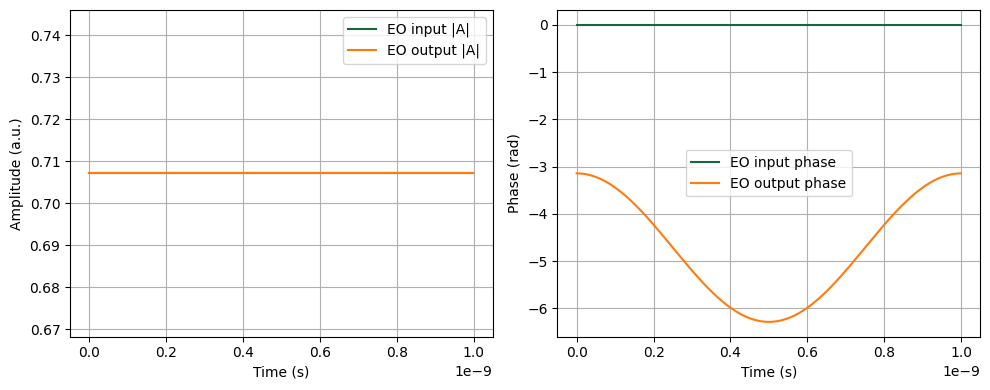

In [14]:
# Get the reference from the MZM to access its ports for monitoring
eo_ref = mzm.references[2]  # Electro-optic phase shifter

ts_mon = mzm.setup_time_stepper(
    time_step=time_step,
    carrier_frequency=f_c,
    time_stepper_kwargs={
        "frequencies": np.linspace(f_c - 200 * f_m, f_c + 200 * f_m, 100),
        "monitors": {
            "eo_in": eo_ref["P0"],
            "eo_out": eo_ref["P1"],
        },
    },
)

# Reset the time-stepper before running with monitors
ts_mon.reset()

# Run the simulation to collect monitor signals
outputs_mon = ts_mon.step(inputs)

# Extract time axis and complex envelopes from monitors
eo_in = outputs_mon["eo_in@0-"]  # '-' sign indicates incoming wave
eo_out = outputs_mon["eo_out@0+"]  # '+' sign indicates outgoing wave

# ... rest of the plotting code
# Create a single figure with two stacked subplots sharing the time axis
fig, (ax_amp, ax_phase) = plt.subplots(1, 2, figsize=(10, 4))

# Plot amplitude at EO input and output
ax_amp.plot(t, np.abs(eo_in), label="EO input |A|")
ax_amp.plot(t, np.abs(eo_out), label="EO output |A|")
ax_amp.set_xlabel("Time (s)")
ax_amp.set_ylabel("Amplitude (a.u.)")
ax_amp.legend()
ax_amp.grid()

# Compute unwrapped phases from complex envelopes
phi_in = np.unwrap(np.angle(eo_in))
phi_out = np.unwrap(np.angle(eo_out))

# Plot phase at EO input and output
ax_phase.plot(t, phi_in, label="EO input phase")
ax_phase.plot(t, phi_out, label="EO output phase")
ax_phase.set_xlabel("Time (s)")
ax_phase.set_ylabel("Phase (rad)")
ax_phase.legend()
ax_phase.grid()

# Finalize layout and render
fig.tight_layout()
plt.show()

In this notebook, we implemented a **relatively simple EO phase shifter model** that applies an ideal, voltage-controlled phase shift to the optical field. While this is sufficient to capture the essential behavior of a Mach–Zehnder Modulator and validate its time-domain operation, **real-world modulators** often involve additional physical effects, including:

- Bandwidth limitations due to electrode design and parasitics  
- Frequency-dependent Vπ and loss  
- Thermal and carrier-induced nonlinearities  
- Traveling-wave effects and reflections  

PhotonForge is designed to support **increasing model complexity**, whether through extensions of the `TimeStepper` class or by using custom hybrid models. We also encourage you to **experiment with your own time-domain models**. The modular structure of PhotonForge allows you to create and register your own component behaviors using the same `TimeStepper` infrastructure demonstrated here.

This example serves as a foundation—ready to be extended toward more physically detailed models and system-level simulations.
